In [22]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import glob as glob
matplotlib.style.use('ggplot')
import itertools

In [2]:
temperature = glob.glob("met18000/yr2001-2012/*.xls")

list_ = []
for file_ in temperature:
    df = pd.read_excel(file_)
    list_.append(df)
    allTemps = np.concatenate(list_)

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [181]:
temp_df = pd.DataFrame(allTemps)
temp_df.columns = ['stn_name', 'stn_code', 'year', 'month', 'dday', 'maxtemp', 'mintemp', 'rain', 'avgrh', 'meantemp']

In [4]:
import re
# s = "Surat Thani Agromet"
# s = re.sub('[^0-9a-zA-Z ]+', '', s)
# print s

def clean_stn_name(name):
    if '\t' in name:
        cleaned_name = name.split('\t')[1]
        return re.sub('[^0-9a-zA-Z ]+', '', cleaned_name)
    else:
        return re.sub('[^0-9a-zA-Z ]+', '', name)
    


In [182]:
temp_df['stn_name'] = temp_df['stn_name'].astype('str').apply(clean_stn_name)

### map stn_code to stn_name for later use

In [6]:
dict_temp = []
for i in range(len(temp_df)):
    if i % 4383 == 0:
        code = temp_df.iloc[i].stn_code
        name = temp_df.iloc[i].stn_name
        dict_temp.append((code,name))
        
code_name = dict(dict_temp)

### "stn_name","stn_code","year","month","dday","maxtmp","mintmp","rain","avgrh","meantemp"

In [7]:
wrong_maxtemp = pd.read_excel("met18000/yr2013-2016/maxtemp-1.xls")
wrong_mintemp = pd.read_excel("met18000/yr2013-2016/mintemp-1.xls")
wrong_humidity = pd.read_excel("met18000/yr2013-2016/rh-1.xls")
wrong_rain = pd.read_excel("met18000/yr2013-2016/rain-1.xls")


## '410201' doesn't have full set of data -> eliminate it out

In [8]:
def structuring_data(arr):
    arr = arr.drop(arr.index[[0,1,2,3]])
    info = np.array(['idx','stn_code', 'date'])
    arr.columns = np.concatenate((info,np.array([str(i) for i in range(1,33)])))
    arr.drop('idx',axis=1,inplace=True)
    arr = arr.rename(columns={'32':'avg'})
    arr = arr.dropna()
    return arr


In [9]:
maxtemp = glob.glob("met18000/yr2013-2016/maxtemp-*.xls")
mintemp = glob.glob("met18000/yr2013-2016/mintemp-*.xls")
humidity = glob.glob("met18000/yr2013-2016/rh-*.xls")
rain = glob.glob("met18000/yr2013-2016/rain-*.xls")

# list_ = []
# for idx,file_ in enumerate(maxtemp):
#     df = pd.read_excel(file_)
#     df = structuring_data(df)
#     list_.append(df)
#     wrong_maxtemp = np.concatenate(list_)

In [10]:
def get_weather_xls(filenames):
    list_ = []
    for idx,file_ in enumerate(filenames):
        df = pd.read_excel(file_)
        df = structuring_data(df)
        list_.append(df)
        all_files = np.concatenate(list_)
    return all_files

In [11]:
wrong_maxtemp = pd.DataFrame(get_weather_xls(maxtemp))
wrong_mintemp = pd.DataFrame(get_weather_xls(mintemp))
wrong_humidity = pd.DataFrame(get_weather_xls(humidity))
wrong_rain = pd.DataFrame(get_weather_xls(rain))

In [12]:
all_provinces_maxtemp = wrong_maxtemp.ix[:,0].apply(clean_stn_name)
all_provinces_mintemp = wrong_mintemp.ix[:,0].apply(clean_stn_name)
all_provinces_humidity = wrong_humidity.ix[:,0].apply(clean_stn_name)
all_provinces_rain = wrong_rain.ix[:,0].apply(clean_stn_name)

In [13]:
def col_names(df):
    info = np.array(['stn_code', 'date'])
    df.columns = np.concatenate((info,np.array([str(i) for i in range(1,33)])))
    return df

def rm_lack_data(to_fix_data,provinces):
    counts = dict()
    bad_data = 0
    lack_data_row = []
    for i in provinces:
        counts[i] = counts.get(i,0) + 1
    
    for stn, freq in counts.iteritems():
        if freq < 45:
            bad_data = int(stn)
    
    for idx,ele in enumerate(provinces):
        if int(ele) == bad_data:
            lack_data_row.append(idx)
            
    to_fix_data = to_fix_data.drop(lack_data_row).reset_index(drop=True)
    fixed_data = to_fix_data
    return fixed_data

In [14]:
wrong_maxtemp = col_names(rm_lack_data(wrong_maxtemp,all_provinces_maxtemp))
wrong_mintemp = col_names(rm_lack_data(wrong_mintemp,all_provinces_mintemp))
wrong_humidity = col_names(rm_lack_data(wrong_humidity,all_provinces_humidity))
wrong_rain = col_names(rm_lack_data(wrong_rain,all_provinces_rain))

In [15]:
len(wrong_rain),len(wrong_maxtemp),len(wrong_mintemp),len(wrong_humidity)

(3060, 3060, 3060, 3015)

In [1410]:
# all data are here
# already combine them all into 4 different feature
# 
# seperate them by province (every 45 sets of data)

In [1411]:
k = [i+1 for i in range(12)]
for i in k:
    if i % 3 == 0:
        print i - 3, i

0 3
3 6
6 9
9 12


### temperature data is collected monthly since 2013-01-01 till 2016-09-01. 
#### That is 36 + 9 -> 45 months of data per every province

In [16]:
import re
def replace_dash(val):
    return re.sub('[^0-9. ]+', '0', val)

def clean_date(date):
    if str(date)[0] == "0":
        return str(date)[1]
    else:
        return date

def rm_extras(standard,n,arr):
    if n > 0:
        to_del_idx = np.random.choice(standard,n)
        arr = np.delete(arr,to_del_idx)
        return arr
    else:
        return arr

In [149]:
date_range = pd.date_range(start='2013-01-01 00:00:00',end='2016-09-03 00:00:00',freq='D')
date_range = pd.Series(date_range.astype('str'))
dday = date_range.str[-2:].apply(clean_date)
mth = date_range.str[5:7].apply(clean_date)
yr = date_range.str[:4]

In [150]:
len(dday)

1342

In [198]:
# calculate 45 data at a time
# for maxtemp and mintemp

# temp_df = pd.DataFrame(columns=['maxtemp','mintemp','avgrh','rain','date','dday','month','year'])
ls_ = []
ct = 0
for i in range(len(wrong_maxtemp)):
    if ((i+1) % 45) == 0:
        station_code = str(wrong_maxtemp.iloc[i].T[0][:6])
#         print station_code, ct
        station_name = code_name.get(int(station_code))
        ct += 1
        
        year_maxtemp = []
        year_mintemp = []
        year_humidity = []
        year_rain = []
        
        try:
            for j in range(i-44,i+1):

                max_monthly = wrong_maxtemp.iloc[j].T[2:-1]
                min_monthly = wrong_mintemp.iloc[j].T[2:-1]
                humid_monthly = wrong_humidity.iloc[j].T[2:-1]
                rain_monthly = wrong_rain.iloc[j].T[2:-1]

                year_maxtemp.append(max_monthly)
                year_mintemp.append(min_monthly)
                year_humidity.append(humid_monthly)
                year_rain.append(rain_monthly)

                a = np.array(list(itertools.chain.from_iterable(year_maxtemp)))
                b = np.array(list(itertools.chain.from_iterable(year_mintemp)))
                c = np.array(list(itertools.chain.from_iterable(year_humidity)))
                d = np.array(list(itertools.chain.from_iterable(year_rain)))

                max_rm = np.array([i for i,e in enumerate(a) if e =='-'])
                min_rm = np.array([i for i,e in enumerate(b) if e =='-'])
                humid_rm = np.array([i for i,e in enumerate(c) if e =='-'])

                a = np.delete(a,max_rm)
                a = a.astype('f')

                b = np.delete(b,min_rm)
                b = b.astype('f')

                c = np.delete(c,humid_rm)
                standard = len(a)
                c_to_del_n = len(c) - standard
                c = rm_extras(standard,c_to_del_n,c)
                c = c.astype('f')

                d = d[:-31]
                d_to_del_n = len(d) - standard
                d = rm_extras(standard,d_to_del_n,d)
                d = pd.Series(d).apply(replace_dash)

            padding = np.zeros((1342,4))

            padding[:,0] = np.append(a,[0 for i in range(1342-len(a))])
            padding[:,1] = np.append(b,[0 for i in range(1342-len(b))])
            padding[:,2] = np.append(c,[0 for i in range(1342-len(c))])
            padding[:,3] = np.append(d,[0 for i in range(1342-len(d))])

            padding_df = pd.DataFrame(padding)
            padding_df['dday'] = dday
            padding_df['month'] = mth
            padding_df['year'] = yr
            padding_df['stn_code'] = station_code
            padding_df['stn_name'] = station_name

            ls_.append(padding_df)

            new_temperature = np.concatenate(ls_)
        except:
            print "fail at", code_name.get(int(station_code))
            pass


/Users/JohnnyV/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:41: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/Users/JohnnyV/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/Users/JohnnyV/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:47: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


fail at Kamphaeng Phet


In [199]:
fixed_temp_df = pd.DataFrame(new_temperature)
fixed_temp_df.columns = ['maxtemp','mintemp','avgrh','rain','dday','month','year','stn_code','stn_name']

In [200]:
null_idx = fixed_temp_df[(fixed_temp_df.maxtemp == 0) & 
              (fixed_temp_df.mintemp == 0) & 
              (fixed_temp_df.avgrh == 0) & 
              (fixed_temp_df.rain == 0)].index

fixed_temp_df = fixed_temp_df.drop(fixed_temp_df.index[[null_idx]])
fixed_temp_df['meantemp'] = (fixed_temp_df['maxtemp'] + fixed_temp_df['mintemp'])/2.

In [264]:
combine_weather = pd.concat([temp_df,fixed_temp_df],ignore_index=True)

def clean_decimal(number):
    return float("%.2f"%number)

def clean_date(date):
    if len(str(date)) == 1:
        return "0" + str(date)
    else:
        return str(date)
    
combine_weather['rain'] = combine_weather['rain'].astype('f').apply(clean_decimal)
combine_weather['maxtemp'] = combine_weather['maxtemp'].astype('f').apply(clean_decimal)
combine_weather['mintemp'] = combine_weather['mintemp'].astype('f').apply(clean_decimal)
combine_weather['meantemp'] = combine_weather['meantemp'].astype('f') .apply(clean_decimal)
combine_weather['avgrh'] = combine_weather['avgrh'].astype('f').apply(clean_decimal)

combine_weather['month'] = combine_weather['month'].apply(clean_date)
combine_weather['dday'] = combine_weather['dday'].apply(clean_date)

combine_weather['date'] = combine_weather['year'].astype('str') + "-" + \
                  combine_weather['month'].astype('str') + "-" + \
                  combine_weather['dday'].astype('str')


In [266]:
combine_weather['date'] = pd.DatetimeIndex(combine_weather.date)
combine_weather = combine_weather.set_index('date')

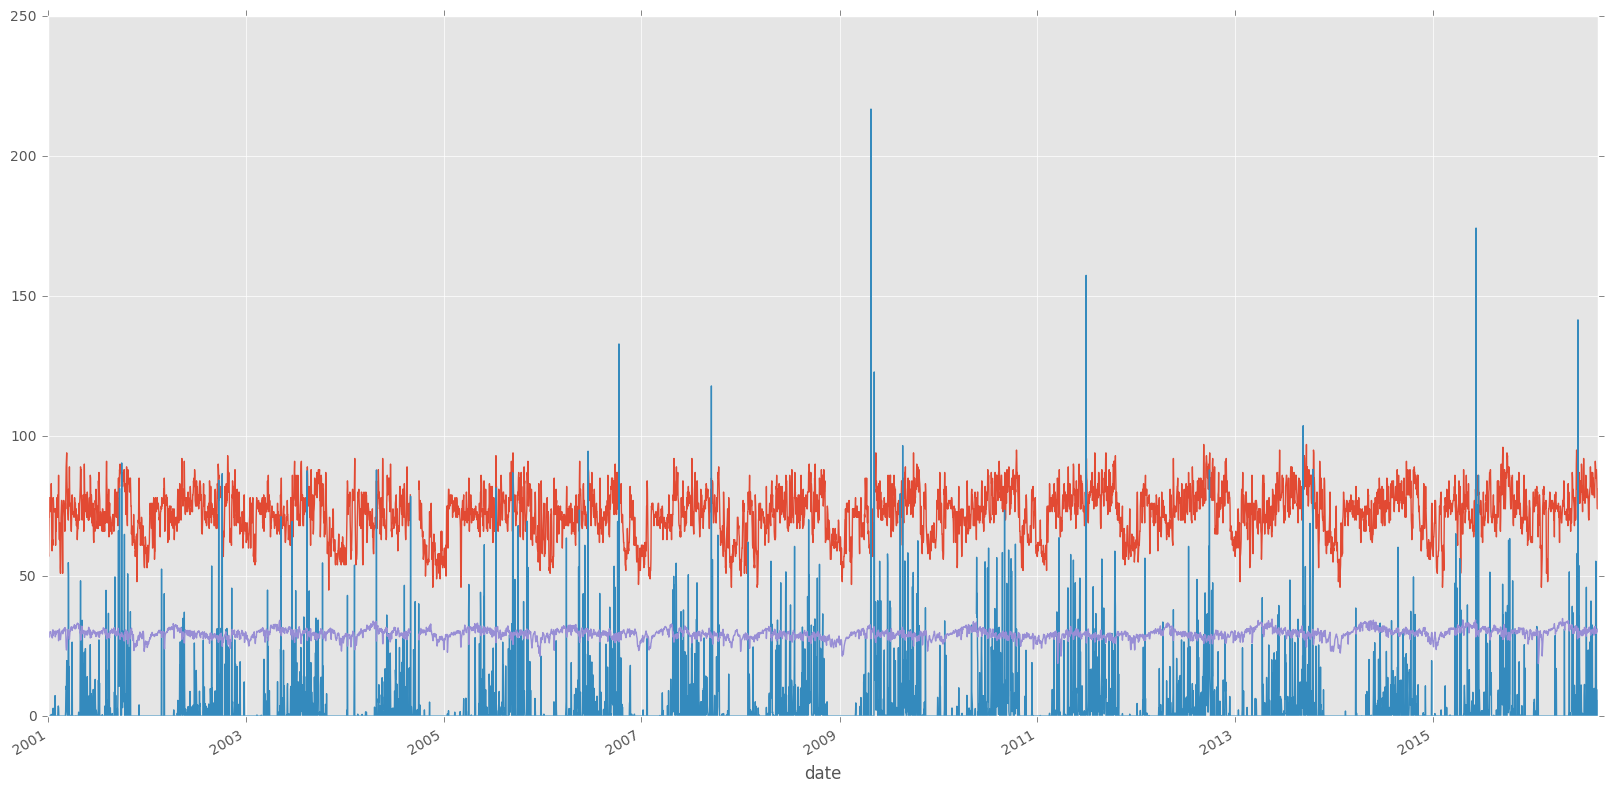

In [267]:
bkk = combine_weather[combine_weather.stn_name == 'Bangkok Metropolis']
bkk['avgrh'].plot(figsize=(20,10))
bkk['rain'].plot()
bkk['meantemp'].plot()

In [268]:
# combine_weather.to_csv("weather01-16.csv")

In [272]:
all_weathers = pd.read_csv("weather01-16.csv")